<a href="https://colab.research.google.com/github/algaebrown/ADAR/blob/master/Sesame_PPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/transcript_ppi_nlp
!ls 

/content/gdrive/MyDrive/transcript_ppi_nlp
EEF.ri.csv  NEAT.ri.csv  PPI.csv  Siamese_LSTM.md


In [ ]:
import pandas as pd
import numpy as np
eef = pd.read_csv('EEF.ri.csv')
eef.drop_duplicates(subset = 'RBP', inplace = True)
eef.set_index('RBP', inplace = True)

In [ ]:
ppi = pd.read_csv('PPI.csv').fillna(False)

In [ ]:
ppi.head()

,Unnamed: 0,source,target,Kris,Bioplex,BioGRID,STRING,cosine_dist,NEAT1,Interaction_type,ANY_PPI
0,1,HNRNPC,RBFOX2,False,False,False,False,0.949227,True,False,False
1,2,HNRNPC,IGF2BP1,False,False,False,False,0.948426,True,False,False
2,3,HNRNPC,HNRNPK,False,False,False,True,0.899163,True,False,False
3,4,HNRNPC,SRSF7,False,False,False,True,0.909137,True,False,False
4,5,HNRNPC,IGF2BP3,False,False,False,False,0.831069,True,False,False


In [ ]:
# negative labels

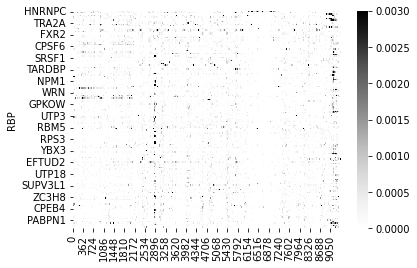

In [ ]:
import seaborn as sns
sns.heatmap(eef, cmap = 'Greys', vmax = 0.003)

In [ ]:
# make it less feature or else it takes forever
def binning_fixed_length(df, length = 50):
  new_data = []
  for i in range(0, df.shape[1], length):
    new_data.append(df.iloc[:, i:i+length].sum(axis = 1))
  new_df = pd.DataFrame(np.stack(new_data).T, index = df.index)
  return new_df

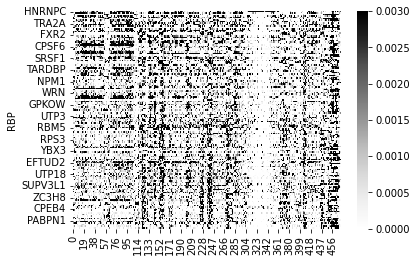

In [ ]:
eef_compact = binning_fixed_length(eef, length = 20)
sns.heatmap(eef_compact, cmap = 'Greys', vmax = 0.003)

In [ ]:
import torch
def get_1_pair(protein_1, protein_2, df = eef):
    return [
            torch.tensor(df.loc[protein_1],dtype = torch.float32),
            torch.tensor(df.loc[protein_2],dtype = torch.float32),
            torch.tensor(ppi.loc[(ppi['source']==protein_1)&(ppi['target']==protein_2), 'ANY_PPI'].values, dtype = torch.float32),
            protein_1,
            protein_2
    ]
def prepare_dataset(pairs, df = eef):
    dataset = [
        get_1_pair(pair[0], pair[1], df = df)
      for pair in pairs]
      
    
    return dataset

In [ ]:
sub_ppi = ppi.loc[(ppi['NEAT1'])].sample(2000)
dataset = sub_ppi[['source', 'target']].values.tolist()

In [ ]:
sub_ppi['ANY_PPI'].value_counts()

False    1824
True      176
Name: ANY_PPI, dtype: int64

In [ ]:
d= prepare_dataset(dataset, df = eef_compact)

In [ ]:
perc_train = 0.8
perc_val = 0.1
perc_test = 0.1

n_train = int(len(dataset)*perc_train)
n_val = int(len(dataset)*perc_val)
n_test = int(len(dataset)*perc_test)
train_data = d[:n_train]
val_data = d[n_train: n_train + n_val]
test_data = d[n_train + n_val:]

# Build the Sesiame network
https://github.com/MarvinLSJ/LSTM-siamese/blob/master/model.py

https://github.com/MarvinLSJ/LSTM-siamese/blob/master/Explanation.ipynb

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
config = {}
config['model'] = defaultdict(dict)
config['model']['embed_size']=1
config['model']['batch_size']=1
config['model']['encoder']['hidden_size']=6
config['model']['encoder']['num_layers']=3
config['model']['encoder']['bidirectional']=True
config['model']['encoder']['dropout']= 0.3
config['model']['fc_dim'] = 3

In [ ]:
from torch import nn
from torch.autograd import Variable
import torch



class LSTMEncoder(nn.Module):
    def __init__(self, config):
        super(LSTMEncoder, self).__init__()
        self.embed_size = config['model']['embed_size']
        self.batch_size = config['model']['batch_size']
        self.hidden_size = config['model']['encoder']['hidden_size']
        self.num_layers = config['model']['encoder']['num_layers']
        self.bidir = config['model']['encoder']['bidirectional']
        if self.bidir:
            self.direction = 2
        else: self.direction = 1
        self.dropout = config['model']['encoder']['dropout']

        #self.embedding = config['embedding_matrix']
        self.lstm = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size, dropout=self.dropout,
                            num_layers=self.num_layers, bidirectional=self.bidir).to(device) # sequence length * batch * n_feature

    def initHiddenCell(self):
        rand_hidden = Variable(torch.randn(self.direction * self.num_layers, self.batch_size, self.hidden_size)).to(device)
        rand_cell = Variable(torch.randn(self.direction * self.num_layers, self.batch_size, self.hidden_size)).to(device)
        return rand_hidden, rand_cell

    def forward(self, input, hidden, cell):
        #input = self.embedding(input).view(1, 1, -1)
        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        return output, hidden, cell


class Siamese_lstm(nn.Module):
    def __init__(self, config):
        super(Siamese_lstm, self).__init__()

        self.encoder = LSTMEncoder(config)
        self.fc_dim = config['model']['fc_dim']

        self.input_dim = 5 * self.encoder.direction * self.encoder.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Linear(self.input_dim, self.fc_dim),
            nn.Linear(self.fc_dim, 2)
        )
        # self.classifier = nn.Sequential(
        #     nn.Linear(self.input_dim, self.input_dim/2),
        #     nn.Linear(self.input_dim/2, 2)
        # )

    def forward(self, s1, s2):

        # init hidden, cell
        h1, c1 = self.encoder.initHiddenCell()
        
        h2, c2 = self.encoder.initHiddenCell()

        # input one by one

        
        for i in range(len(s1)):
          
          v1, h1, c1 = self.encoder(s1[i].unsqueeze(-1), h1, c1)
        for i in range(len(s2)):
          v2, h2, c2 = self.encoder(s2[i].unsqueeze(-1), h2, c2)

        # utilize these two encoded vectors
        features = torch.cat((v1,torch.abs(v1 - v2),v2,v1*v2, (v1+v2)/2), 2)
        # features = v1-v2
        output = self.classifier(features)

        return output

In [ ]:
idx = 0
batch_size = 100
batch_data = train_data[idx:idx+batch_size]
torch.cat([i[0].unsqueeze(-1) for i in batch_data], dim = 1).size()

torch.Size([471, 100])

In [ ]:
def dataloader(data_slice):
  s1 = torch.cat([i[0].unsqueeze(-1) for i in data_slice], dim = 1).unsqueeze(dim=-1).to(device) # length of sequence * batch * nfeature
  s2 = torch.cat([i[1].unsqueeze(-1) for i in data_slice], dim = 1).unsqueeze(dim=-1).to(device)
  label = torch.cat([i[2] for i in data_slice], dim = 0).to(device)
  label = F.one_hot(label.long(), num_classes=2)

  return s1, s2, label


In [ ]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
siamese=Siamese_lstm(config).to(device)
ckpt_path = './Siamese_LSTM.md'

n_epoch = 10
optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, siamese.parameters()), lr=0.01)

true_ppi_weight = 10
loss_weights = Variable(torch.FloatTensor([1, true_ppi_weight])).to(device)
criterion = torch.nn.BCEWithLogitsLoss(weight = loss_weights)
    
# save every epoch for visualization
train_loss_record = []
valid_loss_record = []
best_record = 10.0
batch_size = 2000

# training
# print 'Experiment:{}\n'.format(config['experiment_name'])
epoch = 0

while epoch < n_epoch:
    
    print ('Start Epoch{} Training...'.format(epoch))
    
    # loss
    train_loss = []
    train_loss_sum = []
    
    
    for idx in range(0,len(train_data), batch_size):

        batch_data = train_data[idx:idx+batch_size]
        s1, s2, label = dataloader(batch_data)

        
        # clear gradients
        optimizer.zero_grad()

        # input
        output = siamese(s1, s2)
        output = output.squeeze(1)

        # loss backward
        loss = criterion(output, label.float())
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.cpu())
        train_loss_sum.append(loss.data.cpu())
        
        # Every once and a while check on the loss
        if ((idx + 1) % 5000) == 0:
            print(train_log_string % (datetime.now(), epoch, idx + 1, len(train), np.mean(train_loss)))
            train_loss = []
    
        # Record at every epoch
        print (f'Train Loss at epoch{epoch}, batch index {idx}: {np.mean(train_loss_sum)}\n')
        train_loss_record.append(np.mean(train_loss_sum))

    # # Valid
    print ('Epoch{} Validating...'.format(epoch))

    s1, s2, label = dataloader(val_data)
    output = siamese(s1, s2)
    output = output.squeeze(1)

    valid_loss = criterion(output, label.float())
    valid_loss_record.append(valid_loss.cpu())

    print (f'Val Loss at epoch{epoch}: {valid_loss}\n')

    epoch += 1

    
    
    # Keep track of best record
    if valid_loss < best_record:
        best_record = valid_loss
        # save the best model
        state_dict = {
            'epoch': epoch,
            'siamese': siamese.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state_dict, ckpt_path)
        print ('Model saved!\n')

cuda
Start Epoch0 Training...
Train Loss at epoch0, batch index 0: 3.4916439056396484

Epoch0 Validating...
Val Loss at epoch0: 3.267772674560547

Model saved!

Start Epoch1 Training...


In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_record)
plt.plot(valid_loss_record)

In [ ]:
# get validation data
s1, s2, label = dataloader(test_data)
output = siamese(s1, s2)
output = output.squeeze(1)

valid_loss = criterion(output, label.float())

print (f'Val Loss at epoch{epoch}: {valid_loss}\n')

In [ ]:
label

In [ ]:
output